Predction of IDHM of brazilian cities based on data about location, population age, amount basic sanitation companies, vehicles and so on.

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

#Load the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#load data
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/Brazilian_Cities-incomp-RandomForest/BRAZIL_CITIES.csv',
               sep=';')

The dataframe looks like this:

In [18]:
df.head(2)

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,IDHM Ranking 2010,IDHM,IDHM_Renda,IDHM_Longevidade,IDHM_Educacao,LONG,LAT,ALT,PAY_TV,FIXED_PHONES,AREA,REGIAO_TUR,CATEGORIA_TUR,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,...,GDP_CAPITA,GVA_MAIN,MUN_EXPENDIT,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,HOTELS,BEDS,Pr_Agencies,Pu_Agencies,Pr_Bank,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
0,Abadia De Goiás,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,69.0,318.0,438.0,517.0,3542.0,416.0,319.0,1843.0,1689.0,0.708,0.687,0.830,0.622,-49.440548,-16.758812,893.60,360.0,842.0,147.26,NaN,NaN,8583.0,Urbano,6.20,27991.25,74750.32,36915.04,145857.60,20554.2,166.41,...,20664.57,Demais serviços,28227691.0,284.0,5.0,1.0,56.0,0.0,2.0,29.0,110.0,26.0,4.0,5.0,0.0,2.0,10.0,12.0,4.0,6.0,6.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2158.0,1246.0,0.0,NaN,NaN,NaN,1.0
1,Abadia Dos Dourados,MG,0,6704.0,6704.0,0.0,2328.0,1481.0,847.0,4154.0,38.0,207.0,260.0,351.0,2709.0,589.0,4479.0,18017.0,2207.0,0.690,0.693,0.839,0.563,-47.396832,-18.487565,753.12,77.0,296.0,881.06,Caminhos Do Cerrado,D,6972.0,Rural Adjacente,50524.57,25917.70,62689.23,28083.79,167215.28,12873.5,180.09,...,25591.70,Demais serviços,17909274.0,476.0,6.0,6.0,30.0,1.0,2.0,34.0,190.0,70.0,28.0,11.0,0.0,4.0,15.0,29.0,2.0,9.0,14.0,6.0,19.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2227.0,1142.0,0.0,NaN,NaN,NaN,1.0


#####Pipe1

In [19]:
#defining columns with useless data to out model or to avoid data leakage
bad_columns = ['CATEGORIA_TUR','CITY', 'IDHM Ranking 2010', 'IDHM_Renda', 
               'IDHM_Longevidade', 'IDHM_Educacao', 'LONG', 'LAT', 'GVA_MAIN', 
               'REGIAO_TUR', 'MUN_EXPENDIT', 'HOTELS', 'BEDS', 'Pr_Agencies', 
               'Pu_Agencies', 'Pr_Bank', 'Pu_Bank', 'Pr_Assets', 'Pu_Assets',
               'UBER','MAC','WAL-MART']
               
#drop bad columns
def drop_bad_cols_cattur(df):
  df1=df.copy()
  df1.drop(bad_columns, 
          axis=1, 
          inplace=True)
  return df1

In [20]:
#drop columns where target is null
def drop_null_rows(df):
  return df.dropna(subset=['IDHM'])

In [21]:
#making the functions into transformers for the Pipeline() class
get_drop_bad_cols_incial = FunctionTransformer(drop_bad_cols_cattur)
get_drop_row_null_target = FunctionTransformer(drop_null_rows)

#pipeline to remove bad columns and rows with missing target
pipe_inicial = make_pipeline(get_drop_bad_cols_incial, get_drop_row_null_target)

# df with bad columns and rows with na in target removed
df_sem_cols_nan = pipe_inicial.fit_transform(df)

In [22]:
df_sem_cols_nan.head(2)

,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,IDHM,ALT,PAY_TV,FIXED_PHONES,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,POP_GDP,GDP_CAPITA,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,Cars,Motorcycles,Wheeled_tractor,POST_OFFICES
0,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,69.0,318.0,438.0,517.0,3542.0,416.0,319.0,1843.0,0.708,893.60,360.0,842.0,147.26,8583.0,Urbano,6.20,27991.25,74750.32,36915.04,145857.60,20554.2,166.41,8053.0,20664.57,284.0,5.0,1.0,56.0,0.0,2.0,29.0,110.0,26.0,4.0,5.0,0.0,2.0,10.0,12.0,4.0,6.0,6.0,1.0,5.0,0.0,0.0,2158.0,1246.0,0.0,1.0
1,MG,0,6704.0,6704.0,0.0,2328.0,1481.0,847.0,4154.0,38.0,207.0,260.0,351.0,2709.0,589.0,4479.0,18017.0,0.690,753.12,77.0,296.0,881.06,6972.0,Rural Adjacente,50524.57,25917.70,62689.23,28083.79,167215.28,12873.5,180.09,7037.0,25591.70,476.0,6.0,6.0,30.0,1.0,2.0,34.0,190.0,70.0,28.0,11.0,0.0,4.0,15.0,29.0,2.0,9.0,14.0,6.0,19.0,0.0,0.0,2227.0,1142.0,0.0,1.0


#Exploratory Data Analysis

In the file cols_explain there's a description of each column in the dataframe

In [23]:
#load columns explanation
cols_explain=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/Brazilian_Cities-incomp-RandomForest/Data_Dictionary.csv',
               sep=';', 
               decimal=',')
#drop empty rows
cols_explain.dropna(axis=0, inplace=True, how='all')

cols_explain.head(3)

,FIELD,DESCRIPTION,REFERENCE,UNIT,SOURCE,Unnamed: 5
0,CITY,Name of the City,NaN,NaN,-,NaN
1,STATE,Name of the State,NaN,NaN,-,NaN
2,CAPITAL,1 if Capital of State,NaN,NaN,-,NaN


##Correlation

The correlation helps us to know the data better, which features are most related to the target or to another feature.

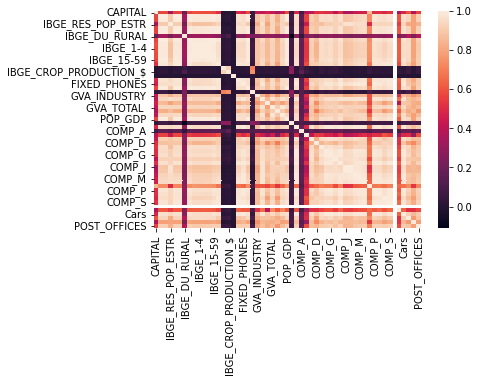

In [30]:
import seaborn as sns

numeric_vars = df_sem_cols_nan.columns.drop(['STATE','RURAL_URBAN','IDHM'],errors='ignore').to_list()
sns.heatmap(df_sem_cols_nan[numeric_vars].corr())

In [25]:
fclassif_drop_vars = ['STATE','RURAL_URBAN','AREA']
#score_func defines the function and k means it will return the k best (highest score) vars
df_fclassif = df_sem_cols_nan.drop(fclassif_drop_vars,axis=1).copy()
df_fclassif_nan = df_fclassif.dropna(axis=0,how='any')
y_fclassif = df_fclassif_nan.IDHM
x_fclassif = df_fclassif_nan.drop('IDHM',axis=1).copy()

algoritmo = SelectKBest(score_func=f_classif, k=10)
best_k_features = algoritmo.fit_transform(x_fclassif,y_fclassif)

scores_fclassif = pd.DataFrame(algoritmo.scores_,x_fclassif.columns)
#print results
print(scores_fclassif.sort_values(by=0, ascending=False).head(10))

                        0
COMP_E           9.255847
COMP_D           9.235137
Wheeled_tractor  9.231580
COMP_H           8.968747
GDP_CAPITA       8.430360
COMP_I           8.315375
COMP_G           8.281256
GVA_INDUSTRY     8.239485
PAY_TV           8.222975
Motorcycles      8.141012


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [49] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


COMP_E and COMP_D seems to be very important to the IDHM of a city. Checking in the `cols_explain`, we see that this columns are the amount of companies that provide Electricity and gas and the amount of companies that provide Water, sewage, waste management and decontamination activities. That makes sanse, this cities have better basic services, so it has a better IDHM.

The surprise is the 3rd place, `Wheeled_tractor` also appear to be a important indicator of IDHM.

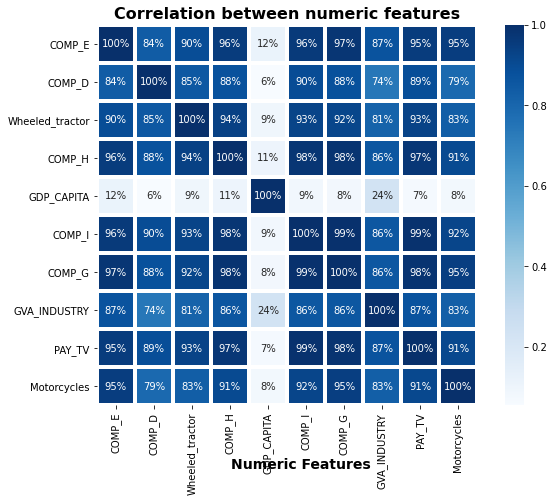

In [ ]:
columns_of_interest = ['COMP_E','COMP_D','Wheeled_tractor','COMP_H','GDP_CAPITA',
                       'COMP_I','COMP_G','GVA_INDUSTRY','PAY_TV','Motorcycles']

# Correlation between numeric variables
fig=plt.figure(figsize=(10,7))
axis=sns.heatmap(x_fclassif[columns_of_interest].corr(), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%",)

#styling the plot
axis.set_title('Correlation between numeric features', fontsize=16, weight='bold', y=1.05);
#axis.set_xticklabels(num_var, fontsize=12)
#axis.set_yticklabels(num_var, fontsize=12, rotation=0);

fig.text(0.5, 0.0, 'Numeric Features', ha = 'center', fontsize = 14, weight = 'bold');

##Columns types

Let's find out which columns are dtype object 

In [31]:
object_columns = df_sem_cols_nan.select_dtypes(object).columns
object_columns

Index(['STATE', 'AREA', 'RURAL_URBAN'], dtype='object')

`STATE`, `CATEGORIA_TUR`, `RURAL_URBAN` are actual categorical variables, we're going to One hot econde it.

The `AREA` is a numerical feature but it has commas separating the thousands. We're going to remove the commas and transform the columns in numerical.

In [28]:
numeric_vars = df_sem_cols_nan.columns.drop(['STATE','RURAL_URBAN','IDHM'],errors='ignore').to_list()
categorical_vars = ['STATE','RURAL_URBAN'] 

#declaring selectors to use in column transformers
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)

##Missing Values

In [ ]:
def faltantes_percentual(df):
  """we can see how much (%) of each column is missing """
  print((df.isnull().sum() / len(df.iloc[:,0])*100).sort_values(ascending=False))

In [78]:
faltantes_percentual(df1)

POST_OFFICES              2.120395
IBGE_DU_RURAL             1.329739
Cars                      0.143756
Wheeled_tractor           0.143756
Motorcycles               0.143756
IBGE_DU                   0.053908
IBGE_DU_URBAN             0.053908
AREA                      0.035939
IBGE_RES_POP              0.017969
IBGE_CROP_PRODUCTION_$    0.017969
 GVA_TOTAL                0.017969
GVA_PUBLIC                0.017969
GVA_SERVICES              0.017969
GVA_INDUSTRY              0.017969
GVA_AGROPEC               0.017969
RURAL_URBAN               0.017969
ALT                       0.017969
IBGE_60+                  0.017969
IBGE_PLANTED_AREA         0.017969
IBGE_RES_POP_BRAS         0.017969
IBGE_15-59                0.017969
GDP                       0.017969
IBGE_5-9                  0.017969
IBGE_1-4                  0.017969
IBGE_1                    0.017969
IBGE_POP                  0.017969
IBGE_RES_POP_ESTR         0.017969
IBGE_10-14                0.017969
TAXES               

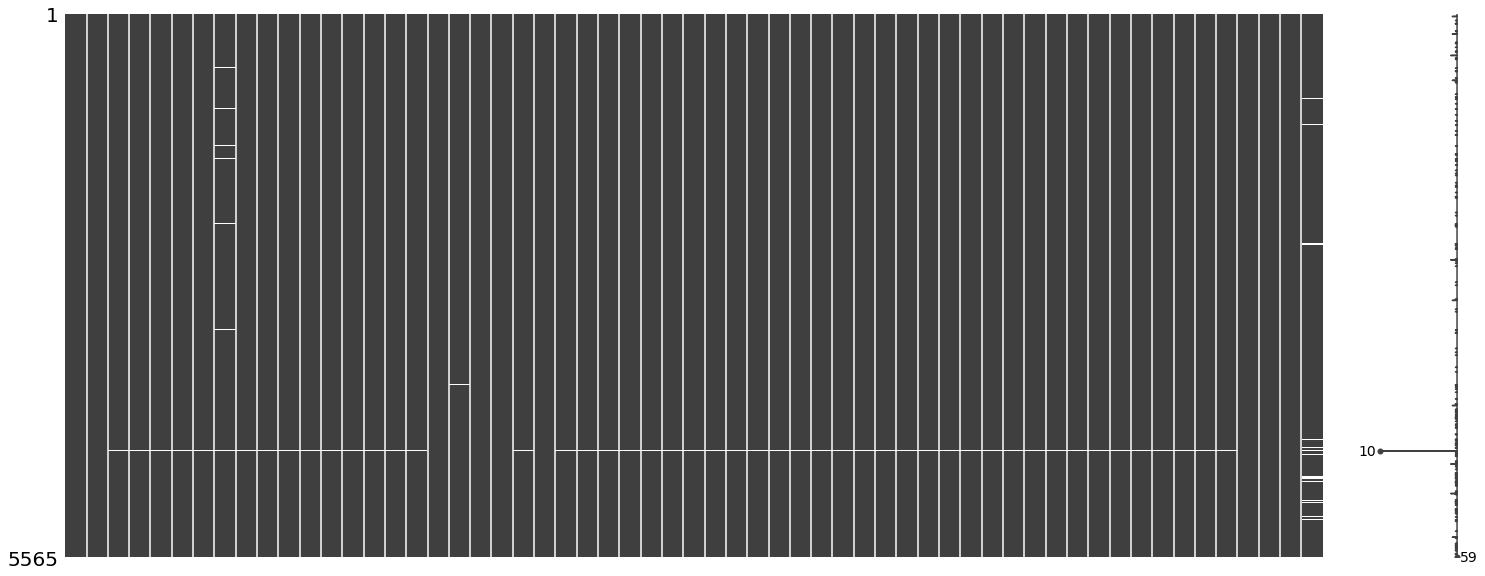

In [80]:
import missingno as mno
mno.matrix(df1)

Most of the features has less than 0.2% missing data and the continuos horizontal line means a few samples are missing a lot of data. Let's drop those samples setting the threshold to more than 40% missing data per sample.

In [113]:
df1.isnull().sum(axis=1).sort_values(ascending=False)

4481    49
2519     4
427      4
4617     4
4919     4
        ..
3645     0
3646     0
3647     0
3648     0
0        0
Length: 5565, dtype: int64

The sample 4481 has 49 missing values, we're removing it.

In [164]:
print(f'number of samples with missing values: {(df1.shape[0] - df1.dropna().shape[0])}, or {round((df1.shape[0] - df1.dropna().shape[0])/len(df1),4)*100}%')

number of samples with missing values: 197, or 3.54%


#Spliting the data

In [36]:
df1 = pipe_inicial.fit_transform(df) #drop_null_rows(df_sem_cols_nan)
x = df1.drop('IDHM', axis=1).copy()
y = df1.IDHM
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=0)

In [37]:
x_train.head(1)

,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,ALT,PAY_TV,FIXED_PHONES,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,POP_GDP,GDP_CAPITA,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,Cars,Motorcycles,Wheeled_tractor,POST_OFFICES
3890,RN,0,13949.0,13949.0,0.0,3365.0,1804.0,1561.0,7399.0,110.0,450.0,696.0,757.0,4577.0,809.0,1153.0,5417.0,88.66,109.0,116.0,230.40,15294.0,Rural Adjacente,6283.53,3.83,17311.89,66527.8,93952.06,2517.95,96470.01,15280.0,6313.48,59.0,0.0,0.0,3.0,0.0,0.0,4.0,43.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,842.0,1462.0,0.0,1.0


#Baseline

Let's build a DecisionTreeRegressor baseline to compare the improvements in the model. We're starting as simple as possible, dropping categorical columns and imputing missing values with the mean of each feature.

In [38]:
def drop_object_cols(df):
  """" drop object type columns"""
  return df.drop(object_columns,axis=1).copy()

get_drop_object_cols = FunctionTransformer(drop_object_cols)

In [59]:
from sklearn.tree import DecisionTreeRegressor
# set up a simple baseline pipeline
pipe_base = Pipeline([
                      ('Drop_cat',get_drop_object_cols),
                      ('Fill_na',SimpleImputer(strategy='mean')),
                      ('model',DecisionTreeRegressor())])

base_score = cross_val_score(pipe_base,x,y,cv=5)

In [60]:
print(base_score.mean())

0.7124479799104178


That's our baseline R2 score: 0.71244 on DecisionTreeRegressor dropping cat cols and imputing missing values with mean.

# Feature Engineer

## Fixing Columns dtype

Let's write a function to erase any commas that might appear in the data and change all numeric feature columns to numeric:

In [71]:
#Remove commas
def erase_commas(df):
  df1 = df.replace(',','', regex=True).copy()
  return df1

In [72]:
def change_to_numeric(df):
  # transforming object columns to numeric
  df[numeric_vars] = df[numeric_vars].apply(pd.to_numeric,errors='raise').copy()

  return df

## Fixing missing values

Let's drop samples with more than 75% of missing data:

In [114]:
df_mv = df1.dropna(axis=0, thresh=df1.columns.shape[0]*0.4)

In [116]:
print(df_mv.shape)
print(df1.shape)

(5564, 59)
(5565, 59)


Sample 4481 removed


### Custom estimator 

In [124]:
class rm_bad_sample(BaseEstimator,TransformerMixin):
  def __init__(self, thresh_limit:int=0.4):
    self.thresh_limit = thresh_limit 
    pass
 
  def fit(self,x:pd.DataFrame ,y:pd.Series=None):
    return self

  def transform(self, df:pd.DataFrame):
    df1 = df.copy()
    return df1.dropna(axis=0, thresh=df1.columns.shape[0]*self.thresh_limit)

Currently, this custom estimator doesn't work properly because it doesn't remove the corresponding sample in the target. I'll think about and fix it latter.

#Pipeline

Let's build a `Pipeline` for preprocessing the data

First, we need to call `FunctionTransformer` to make our functions into transformers so we can use them on the `Pipeline`.

In [173]:
get_erase_commas = FunctionTransformer(erase_commas, validate=False)
get_numeric_feat = FunctionTransformer(change_to_numeric, validate=False)

clean_data = Pipeline([
                  ('Erase Commas',get_erase_commas),
                  ('Change dtype to numeric', get_numeric_feat),
                  #('Remove bad samples', rm_bad_sample(thresh_limit=0.4))
                  ])

In [198]:
#pipeline for columns transformations on categorical features
cat_preprocessing = make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='most_frequent'), 
                OneHotEncoder(handle_unknown='ignore',))

#column transformer to fill na in numeric columns with median
#and fill na in categorical cols with most frequent and apply OneHotEconder
merge_num_cat= ColumnTransformer(
     [("numeric transf", SimpleImputer(missing_values=np.nan, strategy='median'), num_selector),
      ("categorical transf", cat_preprocessing, cat_selector)])

In [199]:
pipe1 = Pipeline([
                  ('Data Cleaning', clean_data), 
                  ('Fill cat with most frequent and num with median and apply OneHotEncoder',merge_num_cat),
                  ('Apply Random Forest Model', RandomForestRegressor(random_state=0))])

In [200]:
score_pipe1 = cross_val_score(pipe1, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_pipe1.mean(),4)} and standard deviation of {score_pipe1.std()}')

accuracy of 0.8646 and standard deviation of 0.005653002115631265


Including the categorical features  `'STATE'` and `'RURAL_URBAN'` and the column `AREA` that had the wrong dtype (object but the feature is numerical), and applying OneHotEncoder to them has increased our model accuracy from  85.65% (baseline) to 86.46%.

## Final Pipeline

Scaling the numerical features:

In [277]:
# numerical preprocessing, impute median and scales the data
num_preprocessing = make_pipeline(SimpleImputer(missing_values=np.nan, 
                                                strategy='median'),
                                  MinMaxScaler())

# merges numerical and categorical preprocessing
merge_pipes= ColumnTransformer(
     [("numeric transf", num_preprocessing, num_selector),
      ("categorical transf", cat_preprocessing, cat_selector)])

# pipeline to clean and preprocess numerical and categorical the data
full_preprocess = Pipeline([
                  ('Data Cleaning', clean_data), 
                  ('Fill cat with most frequent and num with median and apply OneHotEncoder',merge_pipes)])

In [278]:
pipe_final = make_pipeline(full_preprocess,RandomForestRegressor(random_state=0))
score_full = cross_val_score(pipe_final,x,y,cv=5)
print(f'accuracy of {np.round(score_full.mean(),4)} and standard deviation of {score_full.std()}')

accuracy of 0.8722 and standard deviation of 0.005147911725242343


# The Best Model

Let's compare a few different regressors and choose the best performances.

In [ ]:
# regressors search list
grid_base = {'model': [GradientBoostingRegressor(),
                       RandomForestRegressor(),
                       SVR(),
                       SGDRegressor(),
                       DecisionTreeRegressor()]}

# grid search with baseline pipeline
search_models = GridSearchCV(estimator=pipe_base,
                             param_grid=grid_base,
                             n_jobs=-1, 
                             cv=5)
search_models.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Drop_cat',
                                        FunctionTransformer(accept_sparse=False,
                                                            check_inverse=True,
                                                            func=<function drop_object_cols at 0x7f64deabd200>,
                                                            inv_kw_args=None,
                                                            inverse_func=None,
                                                            kw_args=None,
                                                            validate=False)),
                                       ('Fill_na',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                       

In [ ]:
print(search_models.best_estimator_,
      f'\nBest Score: {search_models.best_score_}')

Pipeline(memory=None,
         steps=[('Drop_cat',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function drop_object_cols at 0x7f64deabd200>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('Fill_na',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impu

RandomForest has the best performance with score of 0.8561

In [ ]:
#cross validation in the train data so we don't have to partition it into train 
#and validation and reduce even more the train data
score_base = cross_val_score(search_models.best_estimator_, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_base.mean(),4)} and standard deviation of {score_base.std()}')

accuracy of 0.8565 and standard deviation of 0.006480667393862035


That's the randomforest (best model)  score on cross_val: 0.8565 on numerical vars only and imputing missing value with the mean.

# PCA

Let's normalize the num data with StandardScaler and apply PCA with 30 components to lower the dimensionality of the dataset.

In [ ]:
#pipeline for columns transformations on numeric features
num_prepro_PCA = make_pipeline(
                SimpleImputer(missing_values=np.nan, strategy='median'), 
                StandardScaler(),
                PCA(n_components=10))

#column transformer to fill na in numeric columns with median
#and fill na in categorical cols with most frequent and apply OneHotEconder
merge_PCA= ColumnTransformer(
     [("num", num_prepro_PCA, num_selector),
      ("cat", cat_preprocessing, cat_selector)])

In [ ]:
pipe2 = Pipeline([
                  ('Preprocessing', clean_data), 
                  ('Fill cat(mode) and num(median), OneHot and PCA',merge_PCA),
                  (' Random Forest Model', RandomForestRegressor(random_state=0))])

In [ ]:
score_pipe2 = cross_val_score(pipe2, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_pipe2.mean(),4)} and standard deviation of {score_pipe2.std()}')

accuracy of 0.8103 and standard deviation of 0.004882627001153765


The score now is 81.03%, considerably lower than the baseline so let's drop PCA

#Hyperparameter tunning

## GridSearch

In [196]:
#drop cat features
clean_data_hyper = Pipeline([
                  ('Erase Commas',get_erase_commas),
                  ('Change dtype to numeric', get_numeric_feat),
                  ('drop cat cols', get_drop_object_cols)
                  ])

In [197]:
pipe_hyper = Pipeline([
                  ('Preprocessing', clean_data_hyper),
                  ('Fill_NaN',SimpleImputer(strategy='mean')),
                  ('model_param',RandomForestRegressor())
                  ])

n_estimators_param = [50,100,200]
max_depth = [3,4,5,6]
min_samples_split = [2,3,4,5]
param_grid_RF = [{
              'model_param': [RandomForestRegressor()],
              'model_param__n_estimators': n_estimators_param,
              #'model_param__criterion': ['mse','mae'],
              'model_param__max_depth' : max_depth,
              'model_param__bootstrap' : [False, True],
              'model_param__min_samples_split' : min_samples_split,
              'Fill_NaN__strategy': ['median', 'mean']
           }]
param_grid_GB =[{  
              'model_param': [GradientBoostingRegressor()],
              'model_param__loss': ['ls','lad', 'huber', 'quantile'],
              'model_param__learning_rate': [0.01,0.1,0.5,1,10],
              'model_param__criterion' : ['friedman_mse', 'mse', 'mae'],
              'model_param__min_samples_split' : min_samples_split,
              'Fill_NaN__strategy': ['median', 'mean']    
           }]

In [ ]:
grid_RF = GridSearchCV(pipe_hyper, param_grid=param_grid_RF, cv=5)
grid.fit(x_train, y_train)

In [ ]:
print(grid.best_estimator_,
      f'\nBest Score: {grid.best_score_}',
      f'\nBest Params: {grid.best_params_}')

In [ ]:
print(score_hyper.best_estimator_,
      f'\nBest Score: {score_hyper.best_score_}', score_hyper.best_params_)

In [ ]:
score_hyper.mean()

0.856616057371047

In [ ]:
import pprint as pp

pp.pprint(sorted(pipe_hyper.get_params().keys()))

## Baysian Opt - Optuna

Let's apply the full_preprocess pipeline to the dataset so we can pass it already preprocessed to the study.

In [299]:
x_final = full_preprocess.fit_transform(x)

### LGBM tuning

In [325]:
LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [350]:
# obejctive optimization function
def objective(trial, data=x, target=y):
  """ objetive function to be optmized by optuna """

  # split the data  
  train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)
  # grid params
  lgbm_params ={
    'num_leaves': trial.suggest_int('num_leaves', 200, 1200),
    'max_depth': trial.suggest_int('max_depth', 7,12),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 80,800),
    'learning_rate': trial.suggest_float('learning_rate', 0.01,0.2),
    'n_estimators' : trial.suggest_int('n_estimators',100, 900),
    'lambda_l2' : trial.suggest_float('lambda_l2', 1e-8, 0.01, log=True),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3,1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1,5),
    'random_state': 0,
    'num_threads':-1}
  # the model
  lgbm_model = LGBMRegressor(**lgbm_params)
  # fit the data
  lgbm_model.fit(train_x, train_y)
  # predict
  pred = lgbm_model.predict(valid_x)
  # score
  score = r2_score(valid_y, pred)
  return score

In [352]:
# Create the study
study = optuna.create_study(direction="maximize")

[I 2021-09-23 05:20:53,788] A new study created in memory with name: no-name-87fe8d30-2169-4cd8-b6d9-4d1285f9c49a


In [353]:
# Start the study
study.optimize(lambda trial: objective(trial,
                                       data=x_final,
                                       target=y),
               n_trials=1000)

[I 2021-09-23 05:20:55,322] Trial 0 finished with value: 0.8448879897062619 and parameters: {'num_leaves': 506, 'max_depth': 9, 'min_data_in_leaf': 333, 'learning_rate': 0.19068911415911574, 'n_estimators': 121, 'lambda_l2': 1.5358173786985746e-08, 'bagging_fraction': 0.5509274848056283, 'bagging_freq': 1}. Best is trial 0 with value: 0.8448879897062619.
[I 2021-09-23 05:20:56,916] Trial 1 finished with value: 0.8710489228297827 and parameters: {'num_leaves': 926, 'max_depth': 11, 'min_data_in_leaf': 324, 'learning_rate': 0.18717222287063992, 'n_estimators': 606, 'lambda_l2': 2.0048888013795377e-07, 'bagging_fraction': 0.9657196444169407, 'bagging_freq': 1}. Best is trial 1 with value: 0.8710489228297827.
[I 2021-09-23 05:20:59,071] Trial 2 finished with value: 0.8763476664432892 and parameters: {'num_leaves': 1093, 'max_depth': 8, 'min_data_in_leaf': 361, 'learning_rate': 0.07866035224738716, 'n_estimators': 830, 'lambda_l2': 0.00011108223958374186, 'bagging_fraction': 0.9779948298891

In [354]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    '{}': {},".format(key, value))

lgbm_bestparams = trial.params

Number of finished trials: 1000
Best trial:
  Value: 0.89773631262663
  Params: 
    'num_leaves': 265,
    'max_depth': 8,
    'min_data_in_leaf': 90,
    'learning_rate': 0.03465588572813726,
    'n_estimators': 860,
    'lambda_l2': 0.0015472753387245955,
    'bagging_fraction': 0.8674475747239556,
    'bagging_freq': 4,


In [355]:
lgbm_bestparams = {
    'num_leaves': 265,
    'max_depth': 8,
    'min_data_in_leaf': 90,
    'learning_rate': 0.03465588572813726,
    'n_estimators': 860,
    'lambda_l2': 0.0015472753387245955,
    'bagging_fraction': 0.8674475747239556,
    'bagging_freq': 4}

#Model ensemble - Update


## XGBoost

In [271]:
# does everything above and predict stuff with XGBoost
pipe_xgb = make_pipeline(full_preprocess,
                         XGBRegressor(random_state=0,verbosity=0))
score_xgb = cross_val_score(pipe_xgb, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_xgb.mean(),4)} and standard deviation of {score_xgb.std()}')

accuracy of 0.8691 and standard deviation of 0.00737480751676962


## LGBM

In [358]:
# does everything above and predict stuff
pipe_lgbm = make_pipeline(full_preprocess,
                         LGBMRegressor(random_state=0))
score_lgbm = cross_val_score(pipe_lgbm, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_lgbm.mean(),4)} and standard deviation of {score_lgbm.std()}')

accuracy of 0.8803 and standard deviation of 0.004147711047362714


## Voting

In [359]:
#reference for implementing voting
clf1 = XGBRegressor(random_state=0,verbosity=0)
clf2 = RandomForestRegressor(random_state=0)
clf3 = LGBMRegressor(**lgbm_bestparams)
clf4 = GradientBoostingRegressor(random_state=0)
eclf = VotingRegressor(estimators=[('xgb', clf1), ('rf', clf2), ('lgbm', clf3), ('gb',clf4)],
                       weights=[1,1,5,1])

pipe_vote = make_pipeline(full_preprocess,
                          eclf)

In [360]:
score_vote = cross_val_score(pipe_vote, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_vote.mean(),4)} and standard deviation of {score_vote.std()}')

accuracy of 0.8832 and standard deviation of 0.00618198145301473
